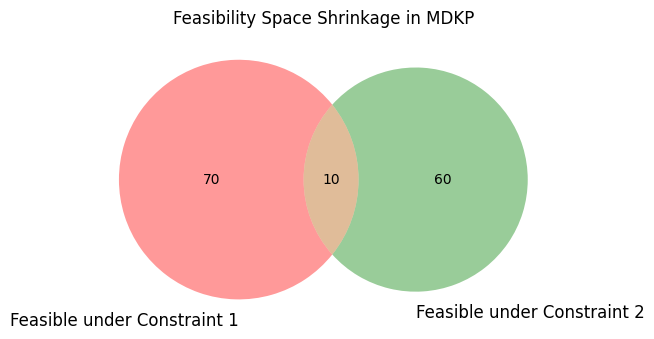

In [ ]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
venn2(subsets = (70, 60, 10), set_labels = ('Feasible under Constraint 1', 'Feasible under Constraint 2'))
plt.title("Feasibility Space Shrinkage in MDKP")
plt.show()


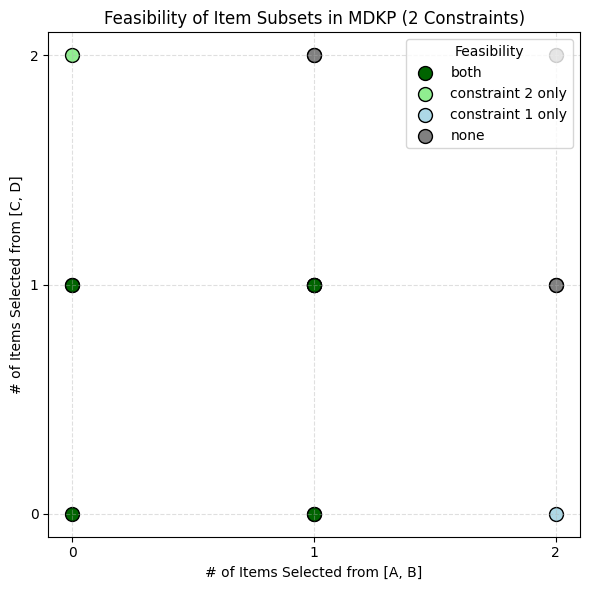

In [1]:
import itertools
import matplotlib.pyplot as plt

# --- Problem Setup: 4 items with values and weights across 2 constraints ---
# Each item has a weight vector (for 2 constraints)
items = {
    'A': [2, 3],
    'B': [1, 4],
    'C': [3, 2],
    'D': [4, 1]
}

# Constraint capacities [for constraint_1, constraint_2]
capacities = [5, 5]

# Enumerate all subsets (16 combinations for 4 items)
item_names = list(items.keys())
combinations = list(itertools.product([0, 1], repeat=len(item_names)))

# Categorize feasibility
results = []

for combo in combinations:
    total_weight_1 = sum(items[item_names[i]][0] for i in range(4) if combo[i] == 1)
    total_weight_2 = sum(items[item_names[i]][1] for i in range(4) if combo[i] == 1)

    feasible_1 = total_weight_1 <= capacities[0]
    feasible_2 = total_weight_2 <= capacities[1]

    if feasible_1 and feasible_2:
        label = 'both'
        color = 'darkgreen'
    elif feasible_1:
        label = 'constraint 1 only'
        color = 'lightblue'
    elif feasible_2:
        label = 'constraint 2 only'
        color = 'lightgreen'
    else:
        label = 'none'
        color = 'gray'

    results.append({
        'combo': combo,
        'x': sum(combo[:2]),   # simple x axis based on inclusion
        'y': sum(combo[2:]),   # simple y axis based on inclusion
        'color': color,
        'label': label
    })

# --- Plotting ---
plt.figure(figsize=(6,6))
seen_labels = set()

for res in results:
    label = res['label'] if res['label'] not in seen_labels else None
    plt.scatter(res['x'], res['y'], color=res['color'], label=label, s=100, edgecolor='black')
    seen_labels.add(res['label'])

plt.title('Feasibility of Item Subsets in MDKP (2 Constraints)')
plt.xlabel('# of Items Selected from [A, B]')
plt.ylabel('# of Items Selected from [C, D]')
plt.xticks(range(3))
plt.yticks(range(3))
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Feasibility')
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
from docplex.mp.model import Model

def parse_mkp_dat_file(file_path):
    """
    Parses a .dat file for the Multidimensional Knapsack Problem (MKP).

    Parameters:
    - file_path: str, path to the .dat file.

    Returns:
    - n: int, number of variables (items).
    - m: int, number of constraints (dimensions).
    - optimal_value: int, the optimal value (if available, otherwise 0).
    - profits: list of int, profit values for each item.
    - weights: 2D list of int, weights of items across constraints.
    - capacities: list of int, capacity values for each constraint.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Read the first line: n (variables), m (constraints), optimal value
    n, m, optimal_value = map(int, lines[0].strip().split())

    # Read the profits for each item
    profits = []
    i = 1
    while len(profits) < n:
        profits.extend(map(int, lines[i].strip().split()))
        i += 1

    # Read the weights (m x n matrix)
    weights = []
    for _ in range(m):
        weight_row = []
        while len(weight_row) < n:
            weight_row.extend(map(int, lines[i].strip().split()))
            i += 1
        weights.append(weight_row)

    # Read the capacities for each dimension
    capacities = []
    while len(capacities) < m:
        capacities.extend(map(int, lines[i].strip().split()))
        i += 1

    # Validate data dimensions
    if len(profits) != n:
        raise ValueError(f"Mismatch in number of items: Expected {n}, got {len(profits)}")
    for row in weights:
        if len(row) != n:
            raise ValueError(f"Mismatch in weights row length: Expected {n}, got {len(row)}")
    if len(capacities) != m:
        raise ValueError(f"Mismatch in number of capacities: Expected {m}, got {len(capacities)}")

    return n, m, optimal_value, profits, weights, capacities

def generate_mkp_instance(file_path):
    """
    Generates a Multidimensional Knapsack Problem (MKP) instance from a .dat file.

    Parameters:
    - file_path: str, path to the .dat file.

    Returns:
    - A dictionary containing the MKP instance details:
        - n: Number of items
        - m: Number of constraints
        - profits: Profit values for each item
        - weights: Weight matrix (m x n)
        - capacities: Capacities for each constraint
    """
    n, m, optimal_value, profits, weights, capacities = parse_mkp_dat_file(file_path)

    mkp_instance = {
        "n": n,
        "m": m,
        "optimal_value": optimal_value,
        "profits": profits,
        "weights": weights,
        "capacities": capacities
    }

    return mkp_instance

def print_mkp_instance(mkp_instance):
    """
    Prints the details of a Multidimensional Knapsack Problem (MKP) instance.

    Parameters:
    - mkp_instance: dict, the MKP instance details.
    """
    print(f"Number of items (n): {mkp_instance['n']}")
    print(f"Number of constraints (m): {mkp_instance['m']}")
    print(f"Optimal value (if known): {mkp_instance['optimal_value']}")
    print("Profits:", mkp_instance['profits'])
    print("Weights:")
    for row in mkp_instance['weights']:
        print(row)
    print("Capacities:", mkp_instance['capacities'])

def create_mkp_model(mkp_instance):
    """
    Creates a CPLEX model for the Multidimensional Knapsack Problem (MKP).

    Parameters:
    - mkp_instance: dict, the MKP instance details.

    Returns:
    - model: CPLEX model.
    - x: list of CPLEX binary variables representing item selection.
    """
    n = mkp_instance['n']
    m = mkp_instance['m']
    profits = mkp_instance['profits']
    weights = mkp_instance['weights']
    capacities = mkp_instance['capacities']

    # Create CPLEX model
    model = Model(name="Multidimensional Knapsack Problem")

    # Decision variables: x[i] = 1 if item i is selected, 0 otherwise
    x = model.binary_var_list(n, name="x")

    # Objective: Maximize total profit
    model.maximize(model.sum(profits[i] * x[i] for i in range(n)))

    # Constraints: Ensure total weights do not exceed capacity for each dimension
    for j in range(m):
        model.add_constraint(
            model.sum(weights[j][i] * x[i] for i in range(n)) <= capacities[j],
            f"capacity_constraint_{j}"
        )

    return model, x


In [7]:
file_path = "instances/hp1.dat"

In [8]:
mkp_instance = generate_mkp_instance(file_path)

# Print the MKP instance details
print_mkp_instance(mkp_instance)

# Create and solve the MKP model
model, x = create_mkp_model(mkp_instance)

Number of items (n): 28
Number of constraints (m): 4
Optimal value (if known): 3418
Profits: [560, 1125, 68, 328, 47, 122, 196, 41, 25, 115, 82, 22, 631, 132, 420, 86, 42, 103, 81, 26, 49, 316, 72, 71, 49, 108, 116, 90]
Weights:
[40, 91, 3, 12, 3, 18, 25, 1, 1, 8, 1, 1, 49, 8, 21, 6, 1, 5, 8, 1, 0, 42, 6, 4, 8, 0, 10, 1]
[16, 92, 4, 18, 6, 0, 8, 2, 1, 6, 2, 1, 70, 9, 22, 4, 1, 5, 6, 0, 4, 8, 4, 3, 0, 10, 0, 6]
[38, 39, 5, 40, 8, 12, 15, 0, 1, 20, 3, 0, 40, 6, 8, 0, 6, 4, 4, 1, 5, 8, 2, 8, 0, 20, 0, 0]
[38, 52, 7, 20, 0, 3, 4, 1, 2, 4, 6, 1, 18, 15, 38, 10, 4, 8, 0, 3, 0, 6, 1, 3, 0, 3, 5, 4]
Capacities: [219, 203, 208, 180]


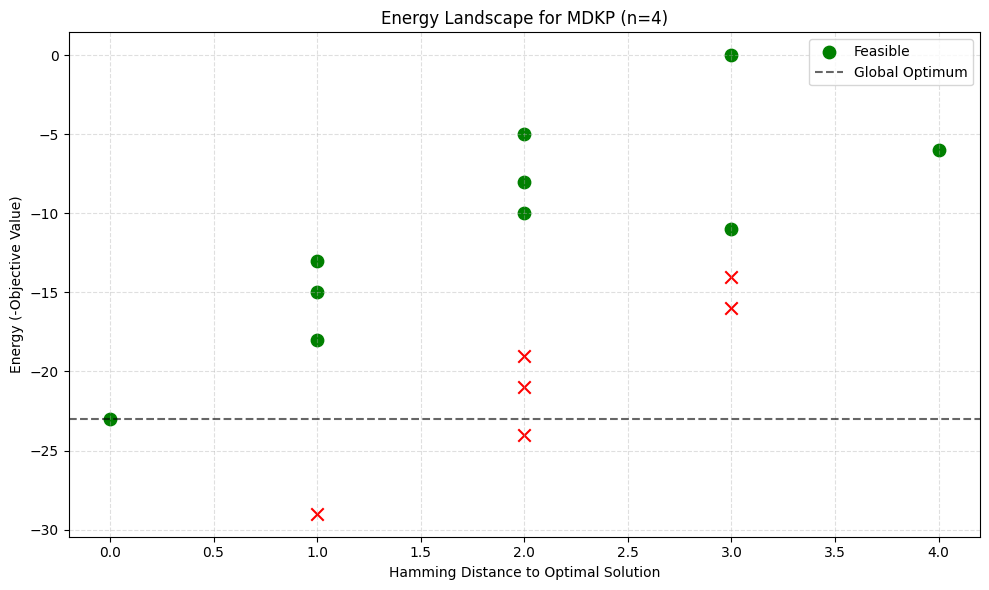

In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Define a small MDKP instance
values = [10, 8, 6, 5]
weights = [
    [2, 3],  # A
    [3, 2],  # B
    [4, 5],  # C
    [1, 2]   # D
]
capacities = [6, 7]
n = len(values)

# Generate all possible binary vectors
solutions = list(itertools.product([0, 1], repeat=n))

# Evaluate all solutions
energy_list = []
feasibility_list = []

for x in solutions:
    value = sum(v * xi for v, xi in zip(values, x))
    weight1 = sum(weights[i][0] * x[i] for i in range(n))
    weight2 = sum(weights[i][1] * x[i] for i in range(n))
    feasible = (weight1 <= capacities[0]) and (weight2 <= capacities[1])
    energy = -value  # energy is negative objective (minimization)
    energy_list.append(energy)
    feasibility_list.append(feasible)

# Find optimal feasible solution
feasible_energies = [e for e, f in zip(energy_list, feasibility_list) if f]
opt_index = energy_list.index(min(feasible_energies))
x_opt = np.array(solutions[opt_index])

# Compute Hamming distance to optimal solution
hamming_dist = [sum(np.array(xi) != x_opt) for xi in solutions]

# Plotting
plt.figure(figsize=(10, 6))
for i, (e, h, f) in enumerate(zip(energy_list, hamming_dist, feasibility_list)):
    color = 'green' if f else 'red'
    marker = 'o' if f else 'x'
    plt.scatter(h, e, color=color, marker=marker, s=80, label='Feasible' if (f and i == 0) else 'Infeasible' if (not f and i == 0) else "")

plt.axhline(y=min(feasible_energies), linestyle='--', color='black', alpha=0.6, label='Global Optimum')
plt.title("Energy Landscape for MDKP (n=4)")
plt.xlabel("Hamming Distance to Optimal Solution")
plt.ylabel("Energy (-Objective Value)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


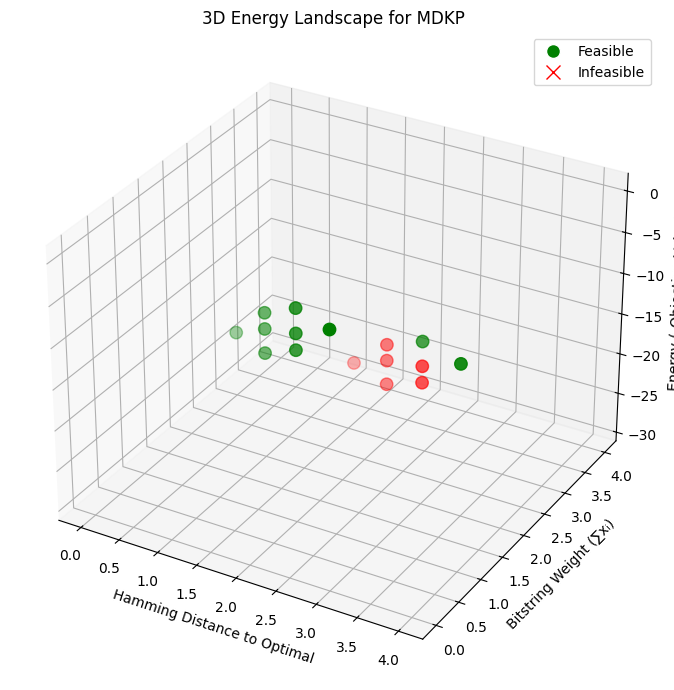

In [2]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define small MDKP instance
values = [10, 8, 6, 5]
weights = [
    [2, 3],  # A
    [3, 2],  # B
    [4, 5],  # C
    [1, 2]   # D
]
capacities = [6, 7]
n = len(values)

# Generate all possible binary vectors
solutions = list(itertools.product([0, 1], repeat=n))

# Evaluate each solution
energy_list = []
weight_sum = []
hamming_dist = []
feasibility_list = []

# Find optimal feasible solution
feasible_energies = []
feasible_solutions = []

for x in solutions:
    value = sum(v * xi for v, xi in zip(values, x))
    w1 = sum(weights[i][0] * x[i] for i in range(n))
    w2 = sum(weights[i][1] * x[i] for i in range(n))
    feasible = (w1 <= capacities[0]) and (w2 <= capacities[1])
    if feasible:
        feasible_energies.append(-value)
        feasible_solutions.append(x)

x_opt = np.array(feasible_solutions[np.argmin(feasible_energies)])

for x in solutions:
    val = sum(v * xi for v, xi in zip(values, x))
    w1 = sum(weights[i][0] * x[i] for i in range(n))
    w2 = sum(weights[i][1] * x[i] for i in range(n))
    feasible = (w1 <= capacities[0]) and (w2 <= capacities[1])

    hamming = sum(np.array(x) != x_opt)
    weight = sum(x)

    energy_list.append(-val)
    weight_sum.append(weight)
    hamming_dist.append(hamming)
    feasibility_list.append(feasible)

# Convert to numpy arrays
X = np.array(hamming_dist)
Y = np.array(weight_sum)
Z = np.array(energy_list)
colors = ['green' if f else 'red' for f in feasibility_list]

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X, Y, Z, c=colors, s=80)

ax.set_xlabel("Hamming Distance to Optimal")
ax.set_ylabel("Bitstring Weight (∑xᵢ)")
ax.set_zlabel("Energy (-Objective Value)")
ax.set_title("3D Energy Landscape for MDKP")

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Feasible', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='x', color='w', label='Infeasible', markerfacecolor='red', markeredgecolor='red', markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


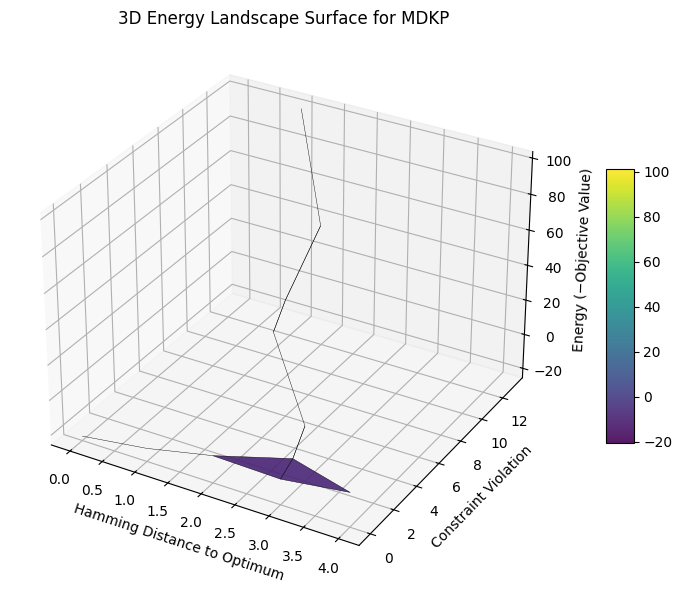

In [4]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define MDKP instance (4 items)
values = [10, 8, 6, 5]
weights = [
    [2, 3],  # A
    [3, 2],  # B
    [4, 5],  # C
    [1, 2]   # D
]
capacities = [6, 7]
n = len(values)

# Enumerate all binary combinations
solutions = list(itertools.product([0, 1], repeat=n))

# Step 1: Find optimal solution
feasible_energies = []
feasible_solutions = []

for x in solutions:
    total_value = sum(v * xi for v, xi in zip(values, x))
    total_w1 = sum(weights[i][0] * x[i] for i in range(n))
    total_w2 = sum(weights[i][1] * x[i] for i in range(n))
    if total_w1 <= capacities[0] and total_w2 <= capacities[1]:
        feasible_energies.append(-total_value)
        feasible_solutions.append(x)

x_opt = np.array(feasible_solutions[np.argmin(feasible_energies)])

# Step 2: Create "grid" inputs — Hamming dist vs constraint violation
grid_hamming = []
grid_violation = []
grid_energy = []

for x in solutions:
    x_arr = np.array(x)
    val = sum(v * xi for v, xi in zip(values, x))
    w1 = sum(weights[i][0] * x[i] for i in range(n))
    w2 = sum(weights[i][1] * x[i] for i in range(n))

    # Constraint-specific violation
    v1 = max(0, w1 - capacities[0])
    v2 = max(0, w2 - capacities[1])

    # Optional: weighted penalty (or treat as 2D features)
    total_violation = 2 * v1 + 1 * v2  # e.g., constraint 1 is more strict

    hamming = sum(x_arr != x_opt)
    energy = -val + (10 * total_violation)  # penalize energy explicitly

    grid_hamming.append(hamming)
    grid_violation.append(total_violation)  # or (v1, v2) if plotting separately
    grid_energy.append(energy)


# Create a 2D grid
hamming_levels = sorted(set(grid_hamming))
violation_levels = sorted(set(grid_violation))
H, V = np.meshgrid(hamming_levels, violation_levels)

# Initialize energy surface
Z = np.full_like(H, fill_value=np.nan, dtype=float)

# Fill energy surface
for h, v, e in zip(grid_hamming, grid_violation, grid_energy):
    i = violation_levels.index(v)
    j = hamming_levels.index(h)
    if np.isnan(Z[i, j]) or e < Z[i, j]:
        Z[i, j] = e  # keep the best energy at each grid cell

# Plot the 3D surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(H, V, Z, cmap='viridis', edgecolor='k', linewidth=0.3, alpha=0.9)

ax.set_title("3D Energy Landscape Surface for MDKP")
ax.set_xlabel("Hamming Distance to Optimum")
ax.set_ylabel("Constraint Violation")
ax.set_zlabel("Energy (−Objective Value)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()
